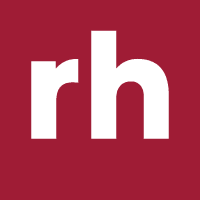

## **Robert Half Data Science Exercise**

---

## Contents

    1. Text Wrangling & EDA

    2. Model Training

    3. Model Testing & Evaluation

    4. Business Insights

In [ ]:
import sys
print(sys.executable)

In [1]:
# Stdlib
import warnings
warnings.filterwarnings("ignore")

import csv
import json
import re
import os
from collections import defaultdict


# Third party
import tqdm
# from tqdm._tqdm_notebook import tqdm_notebook
from tqdm.auto import tqdm
# tqdm_notebook(desc = 'Text processing')
# tqdm_notebook.pandas(desc = 'Text processing')
tqdm.pandas(desc='Text processing')

from pyemd import emd, emd_with_flow

import numpy as np

import pandas as pd
# from pandas.io.json import json_normalize
from pandas import json_normalize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

from sklearn.manifold import TSNE
from sklearn.metrics import euclidean_distances
from sklearn.metrics import classification_report, accuracy_score 

import spacy
from spacy import displacy

from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

from gensim.test.utils import get_tmpfile, datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


from wordcloud import WordCloud, STOPWORDS
import glob

import matplotlib.pyplot as plt

import seaborn as sns
color = sns.color_palette()


from standard_functions import stopwords, DirtPile, PileDistribution


%run -i standard_functions.py

---

# Text Wrangling
## Overview
    ● Original file was not valid json, produced EOF error
        - Inserted a comma after each new line for valid array of objects
        
    ● In the data's rawest format there are bullet points and other unicode artifacts
        - Training this format on more traditional algorithms would present a problem, but neural models are more robust 
          and can exploit this structure as a feature. If the the labels are well defined, and there is enough data to 
          train, a neural model can actively avoid such structure

In [ ]:
# Import annotated dataset

with open('files/annotated_data.json', encoding = 'utf8') as f:
    data = json.loads("[" + f.read().replace("}\n{", "},\n{") + "]")

jsonString = json.dumps(data, indent = 4)
print(jsonString[0:1000000])

    ● Flattening parts of the json and loading it into a dataframe will allow me to perform basic analysis and compare it   
      to the resume data with categories file

In [3]:
# Try removing duplicates

json_df = pd.json_normalize(data, record_path = ['annotation'], meta = ['content'], max_level = 1, errors = 'ignore')

json_df.head()

label  \
0  [Skills]            
1  [Skills]            
2  [College Name]      
3  [College Name]      
4  [Graduation Year]   

                                                                                                                                                                                                                                                                                                                                                                              points  \
0  [{'start': 1295, 'end': 1621, 'text': '
• Programming language: C, C++, Java
• Oracle PeopleSoft
• Internet Of Things
• Machine Learning
• Database Management System
• Computer Networks
• Operating System worked on: Linux, Windows, Mac

Non - Technical Skills

• Honest and Hard-Working
• Tolerant and Flexible to Different Situations
• Polite and Calm
• Team-Player'}]   
1  [{'start': 993, 'end': 1153, 'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),
Database Management System (Less than 1 year), Java (Less than 1 year)'}]                                                                                                                                                                          
2  [{'start': 939, 'end': 956, 'text': 'Kendriya Vidyalaya'}]                                                                                                                                                                                                                                                                                                                          
3  [{'start': 883, 'end': 904, 'text': 'Woodbine modern school'}]                                                                                                                                                                                                                                                                                                                      
4  [{'start': 856, 'end': 860, 'text': '2017
'}]                                                                                                                                                                                                                                                                                                                                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

---

    ● This file is completely corrupted or is just in a format I'm not familiar with
    
            - The dataset was very unstructured and had a lot of inaccuracies
            - I needed more structure before proceeding with EDA
            - When examining the file in excel I tried to find latent structure
            - I noticed text in all caps in the first column that could possibly be categories. The corrupted header eluded 
              to this possibility
              
            - I also noticed two special characters on each possible category. The pattern did not follow for each 
              observation, but it represented a large number of categories
              
            - It was apparent I could split the text on the backquote/double quote pattern and isolate the category from 
              the main body as text for a large number of observations, create a new column for those categories and create 
              more structure

In [4]:
# Import resume categories dataset, combine all the rows into a single string
# Split the string into columns using the special characters as delimiters
# Insert columns in dataframe and show each category at the end of a section of a resume cell


# Try removing duplicates

with open('files/resume_data_with_categories.csv', encoding = 'utf-8') as csv_file:
    csv_reader = csv.reader(csv_file)
    rows = list(csv_reader)

all_rows = ' '.join([' '.join(row) for row in rows])

csv_columns = all_rows.split('`"')

df = pd.DataFrame(csv_columns)
df.columns = df.iloc[0]
df = df.iloc[1: , :]
df.head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

---

    ● Additional cleaning needed for resume categories dataset to remove unique values not relevant to a job title and 
      create seperate resume and category columns

In [5]:
# Take text from column, break it into two separate pieces of text that are put into their own columns
split_text = df["Category`Resume Data Science"].str.split('." |" ')
df["resume"] = split_text.str[0]
df["category"] = split_text.str[1]
df = df.drop('Category`Resume Data Science', axis = 1) 

# Calculate the length of each string in the "Category" column
string_lengths = df["category"].str.len()

# Drop rows with string lengths greater than 30
df = df.drop(string_lengths[string_lengths > 30].index).dropna()

# Count the number of unique values in the "Category" column
num_unique_values = df["category"].nunique()

# Print the number of unique values
print("Number of unique values:", num_unique_values)

# Print the unique values in the "Category" column
print("Unique values:", df["category"].unique())

# Remove returned rows that did not have a category
df = df.loc[~df["category"].str.contains('and ""to-be|Campaigns| ""Research of Oreo Campaigns|software to ""renting|2013. Veterans Affairs Award|and ""Aftercare|State of the Unit |or ""bad|Crossing of America.org|and the ""BIG 50|to=""|Best in People Development |If I were KING|""Personal Care|and ""gatekeeper|    |and the ""brain|and ""just in time|saved=""|my=""|approach that uses ""props|routs  ""K|Mentor Me|E')]
df.head(30)

Number of unique values: 71
Unique values: ['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing' 'Mentor Me'
 'DESIGNER' 'and ""to-be' ' ""Research of Oreo Campaigns'
 'INFORMATION-TECHNOLOGY' 'software to ""renting' 'TEACHER'
 '2013. Veterans Affairs Award' 'ADVOCATE' 'and ""Aftercare'
 'State of the Unit ' 'BUSINESS-DEVELOPMENT' 'or ""bad' 'HEALTHCARE'
 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES' 'Crossing of America.org'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'and the ""BIG 50' 'CHEF'
 'FINANCE' 'to=""' 'APPAREL' 'Best in People Development '
 'If I were KING' '""Personal Care' 'and ""gatekeeper' 'ENGINEERING'
 '    ' 'and the ""brain' 'and ""just i

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

---

# Exploratory Data Analysis

    There are a few assumptions I can make:
        1. The distribution of words between the csv and the annotated data will generally be same. Both datasets are 
           clearly for resumes
           
        2. The distribution of words should follow Zipf's law, so the frequency of words should decrease very rapidly with 
           rank
           
        3. Both datasets should follow a power law, so a small number of words are frequent (common words), while a large 
           number of words are infrequent (rare words)

    Observations:
        ● Technology and people operations are high in demand
        
        ● Counts, lengths and plots are a great way to get familiar with the distribution of data
            - Weighted sums of these frequencies for each dataset can help give context to classification decisions 
              for tasks downstream of EDA. For example, the length of character, word and sentence vectors matter when 
              calculating the distance between observations to measure similarity

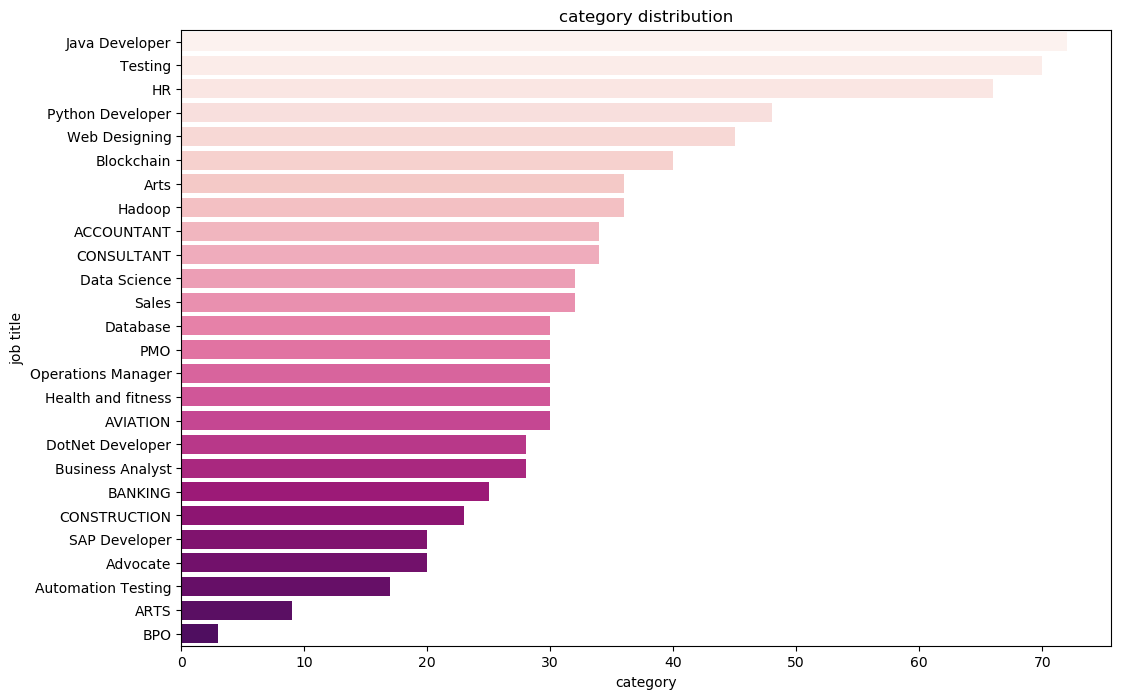

In [6]:
# Bar plot distribution of job titles

category = df['category'].value_counts().reset_index()
category

plt.figure(figsize=(12,8))
sns.barplot(x=category['category'], y=category['index'], palette='RdPu')
plt.ylabel('job title') 
plt.title('category distribution')
plt.show();

In [7]:
# Average/max character length comparison for resume categories dataset
# and annotated dataset

csv_char_counts = analyze_characters(df, 'resume')
json_char_counts = analyze_characters(json_df, 'content')

Average length: 3566
Max length: 17241
Average length: 4481
Max length: 20143


In [8]:
# Average/max word count comparison for resume categories dataset
# and annotated dataset

csv_word_counts = analyze_words(df, 'resume')
json_word_counts = analyze_words(json_df, 'content')

Average count492
Max count: 2294
Average count633
Max count: 2953


In [9]:
# Average/max sentence count and length comparison for 
#resume categories dataset and annotated dataset

csv_sent_counts_df = analyze_sentence_count_len(df, 'resume')
json_sent_counts_df = analyze_sentence_count_len(json_df, 'content')

Average Sentence Count: 23
Average Sentence Length: 31
Average Sentence Count: 27
Average Sentence Length: 37


In [10]:
# Take previous averages for sentences and calculate for statistical plots over all observations

df['sent_csv_count'] = df['resume'].apply(lambda x: len(sent_tokenize(x)))
avg_sent_csv = round(df['sent_csv_count'].mean())

df['avg_sent_csv_len'] = df['resume'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
avg_sent_csv_len = round(np.mean(df['avg_sent_csv_len']))


json_df['sent_json_count'] = json_df['content'].apply(lambda x: len(sent_tokenize(x)))
avg_sent_json = round(json_df['sent_json_count'].mean())

json_df['avg_sent_json_len'] = json_df['content'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
avg_sent_json_len = round(np.mean(json_df['avg_sent_json_len']))

---

### Comparing sentence count and average sentence length between the datasets

    Observations:
        ● The average density between the two are similar 
        ● There's a little bit of information loss
        ● We can assume documents are semantically similar because of similar distributional patterns
        ● Helps if we need to apply smoothing methods like Laplace (watch MLExpert)
        ● There are outliers that may need to be removed
    
        ● It's useful to know the likelihood of different words occuring, so a word having a certain length or of a 
          sentence having a certain number of words. We can get a better understanding of the underlying patterns and 
          structure in the data. For example, we could use these PDFs to model the he distribution of sentence lengths 
          in a corpus in order to identify stylistic features, unusual or unexpected patterns, or generate synthetic 
          text that resembles the corpus
          
          
    Insights based on 'resume data with categories':
    
        ● There are a wide range of mean resume lengths across different categories, with some categories having much longer 
          resumes than others
          
        ● "Operations Manager" and "Consultant," tend to have longer resumes on average, while other categories, such as 
          "Sales" and "Health and fitness," tend to have shorter resumes on average
          
        ● Certain categories, such as "Data Science," "Web Designing," and "Automation Testing," tend to have resumes that 
          are longer than the overall mean length of all the resumes. This could indicate that these categories require 
          more detailed or specialized information in resumes
          
        ● Other categories, such as "HR", "Business Analyst", and "Banking" tend to have resumes that are shorter than the 
          overall mean length of all the resumes. This could indicate that these categories place more emphasis on other 
          factors, such as relevant experience or skills, in resumes
          
        ● This information can be useful for job seekers looking to tailor their resumes to specific categories, and also 
          useful when determining important classification features

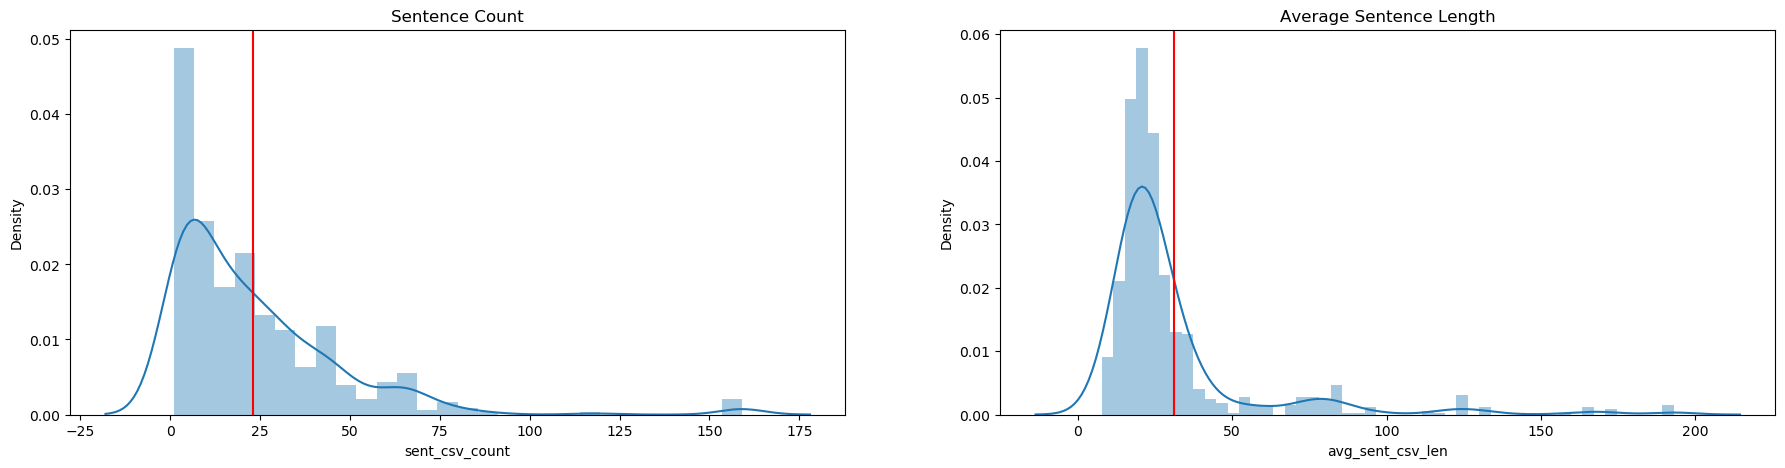

In [11]:
# Resume data with categories 

plt.figure(figsize = (22,5))
for i, col in enumerate(['sent_csv_count','avg_sent_csv_len']):
        title = 'Sentence Count' if i == 0 else 'Average Sentence Length'
        mean = avg_sent_csv if i == 0 else avg_sent_csv_len
        ax = plt.subplot(1, 2, i+1)
        sns.distplot(df[col])
        ax.axvline(x = mean, color = 'red')
        ax.set_title(title)
plt.show()

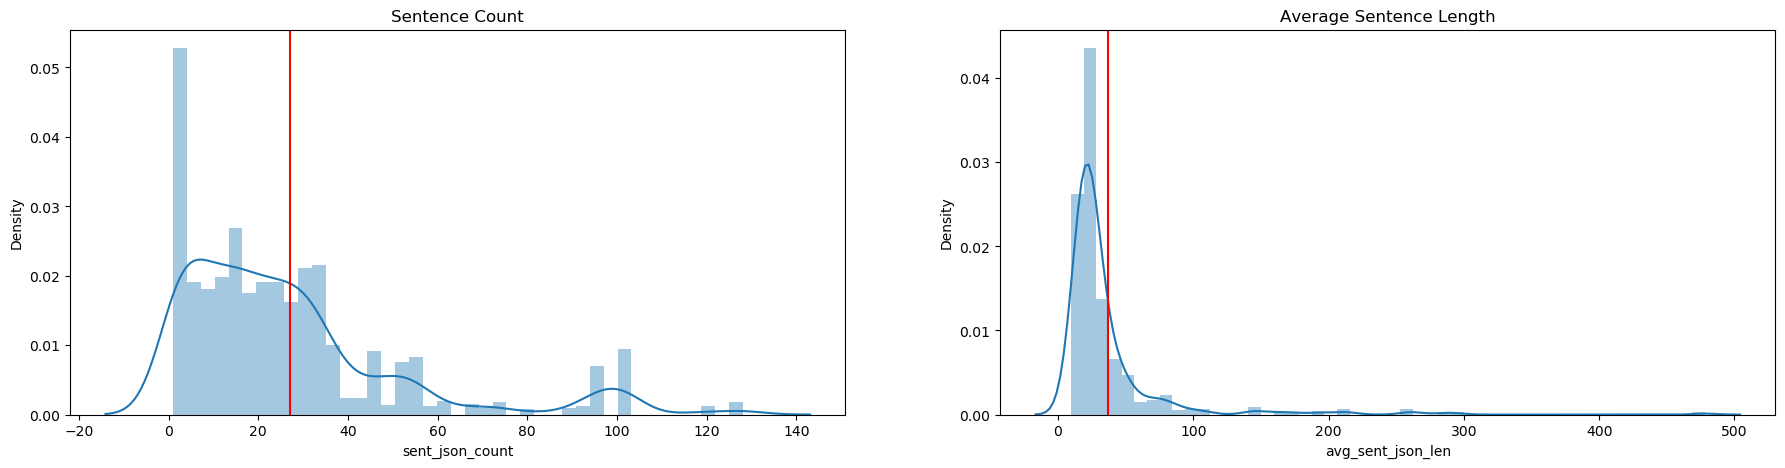

In [12]:
# Annotated resume data

plt.figure(figsize = (22,5))
for i, col in enumerate(['sent_json_count','avg_sent_json_len']):
        title = 'Sentence Count' if i == 0 else 'Average Sentence Length'
        mean = avg_sent_json if i == 0 else avg_sent_json_len 
        ax = plt.subplot(1, 2, i+1)
        sns.distplot(json_df[col])
        ax.axvline(x = mean, color = 'red')
        ax.set_title(title)
plt.show()

In [13]:
# Average resume length
# Group rows by the category column

groups = df.groupby('category')

# Apply mean of resume length to each group

for name, group in groups:
    print(f"Category: {name}")
    print(f"Mean resume length: {mean_resume_length(group)}")

Category: ACCOUNTANT
Mean resume length: 6000.294117647059
Category: ARTS
Mean resume length: 6642.333333333333
Category: AVIATION
Mean resume length: 6418.766666666666
Category: Advocate
Mean resume length: 956.9
Category: Arts
Mean resume length: 2234.1666666666665
Category: Automation Testing
Mean resume length: 4825.235294117647
Category: BANKING
Mean resume length: 5816.04
Category: BPO
Mean resume length: 6217.333333333333
Category: Blockchain
Mean resume length: 2241.8
Category: Business Analyst
Mean resume length: 4898.392857142857
Category: CONSTRUCTION
Mean resume length: 6125.086956521739
Category: CONSULTANT
Mean resume length: 6332.470588235294
Category: Data Science
Mean resume length: 2824.5
Category: Database
Mean resume length: 4230.9
Category: DotNet Developer
Mean resume length: 2734.535714285714
Category: HR
Mean resume length: 2701.242424242424
Category: Hadoop
Mean resume length: 3433.1666666666665
Category: Health and fitness
Mean resume length: 1796.933333333333

In [14]:
# Clean datasets for further analysis
# Special attention for resume data with categories for similarity analysis

df['resume'] = df['resume'].progress_apply(lambda x: clean_resume(x))

df['category'] = df['category'].progress_apply(lambda x: clean_resume(x))

json_df['content'] = json_df['content'].progress_apply(lambda x: clean_resume(x))

csv_df_words = list(df['resume'].values)
json_df_words = list(json_df['content'].values)


# Process data with stopwords
# Which stop words are/aren't important comes down to analysis goals/needs

csv_df_words = get_words(csv_df_words, stopwords)
json_df_words = get_words(json_df_words, stopwords)

Text processing: 100%|██████████| 3558/3558 [00:00<00:00, 6598.16it/s]


    ● Here we can see how many times words related to the job titles are mentioned in a resume for given 
      categories from both datasets
      
    ● The data is very close and similar in terms of language, they carry similar assumptions but they are not 1:1
      
    ● I see a few words that could be candidates for a stop words list. According to our power law, this would be useful 
      for examining features in the Skills label of our annotated dataset
      
          - Assumption: Stop word removal could be sensitive to analysis and depends on downstream goals and needs 
            regarding information retreival for resumes
            
          - I'm certain an SME could help me understand if there are common words that are specific to recruiting other 
            than common English stop words

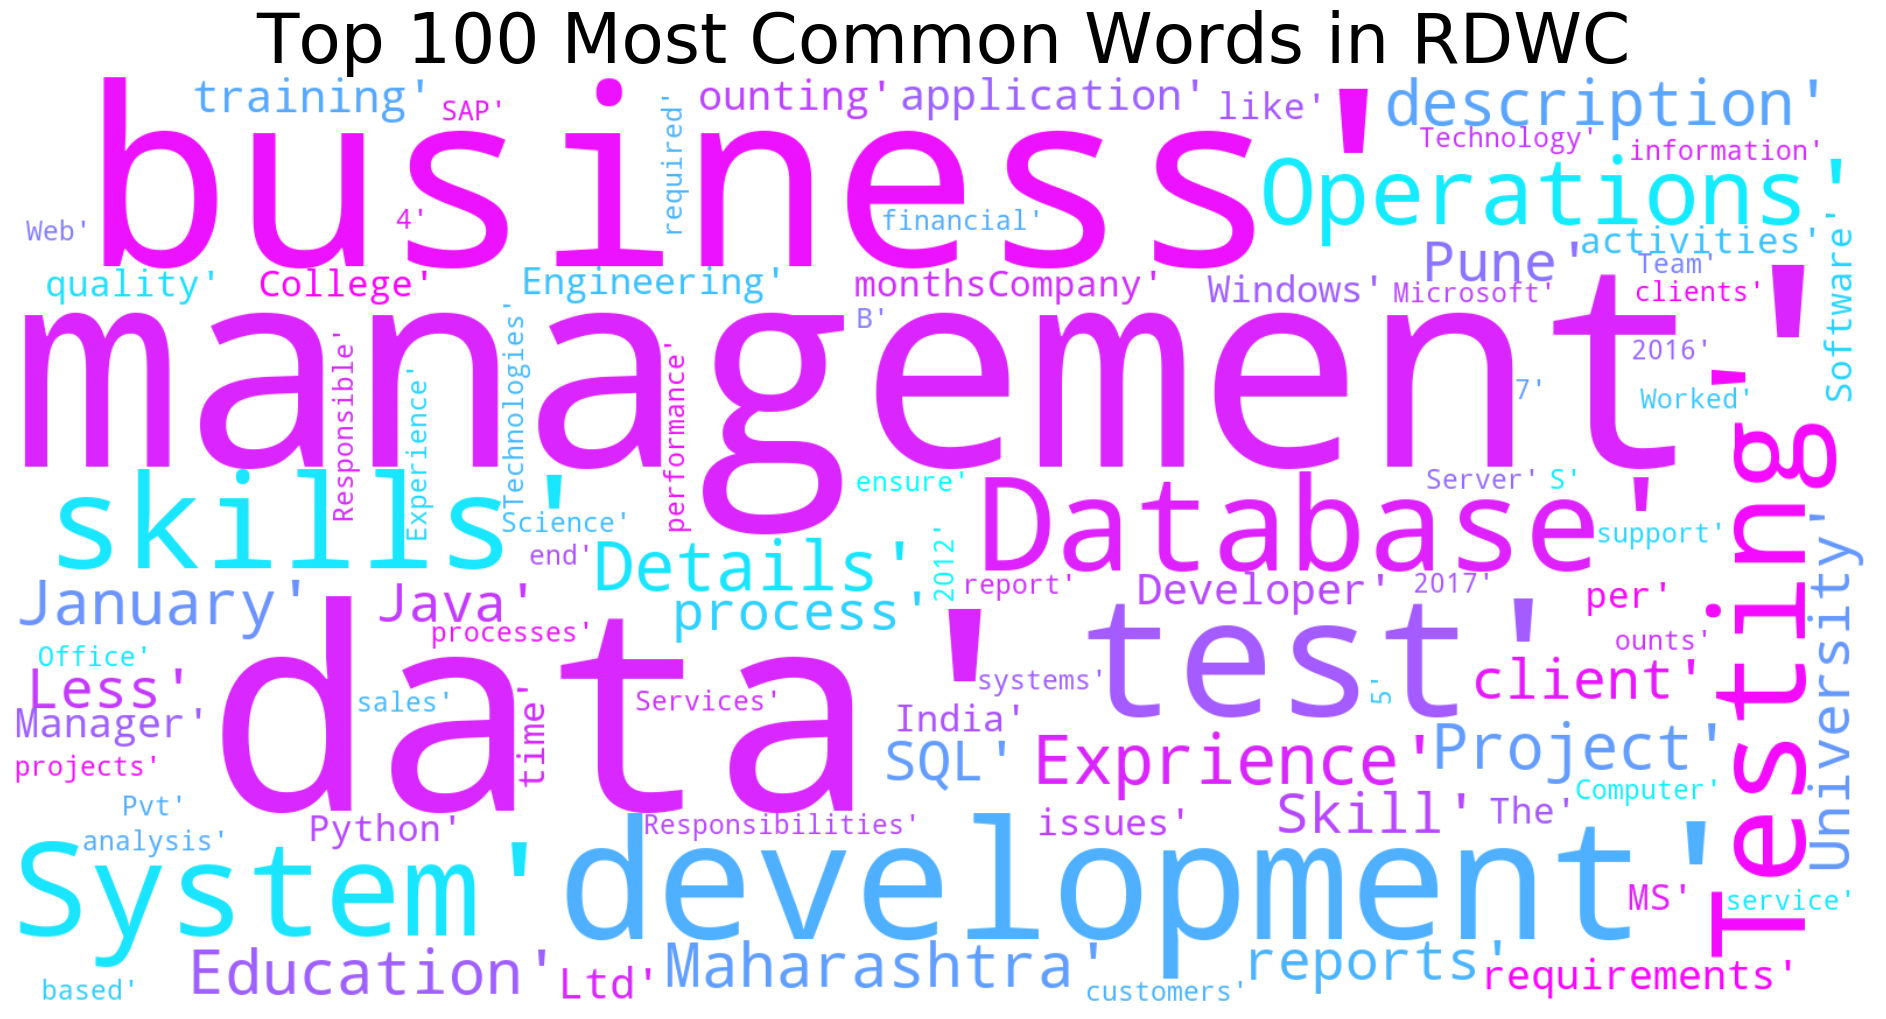

In [15]:
# Resume data with categories

mostcommon = FreqDist(csv_df_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap = 'cool', stopwords=STOPWORDS).generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in RDWC', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

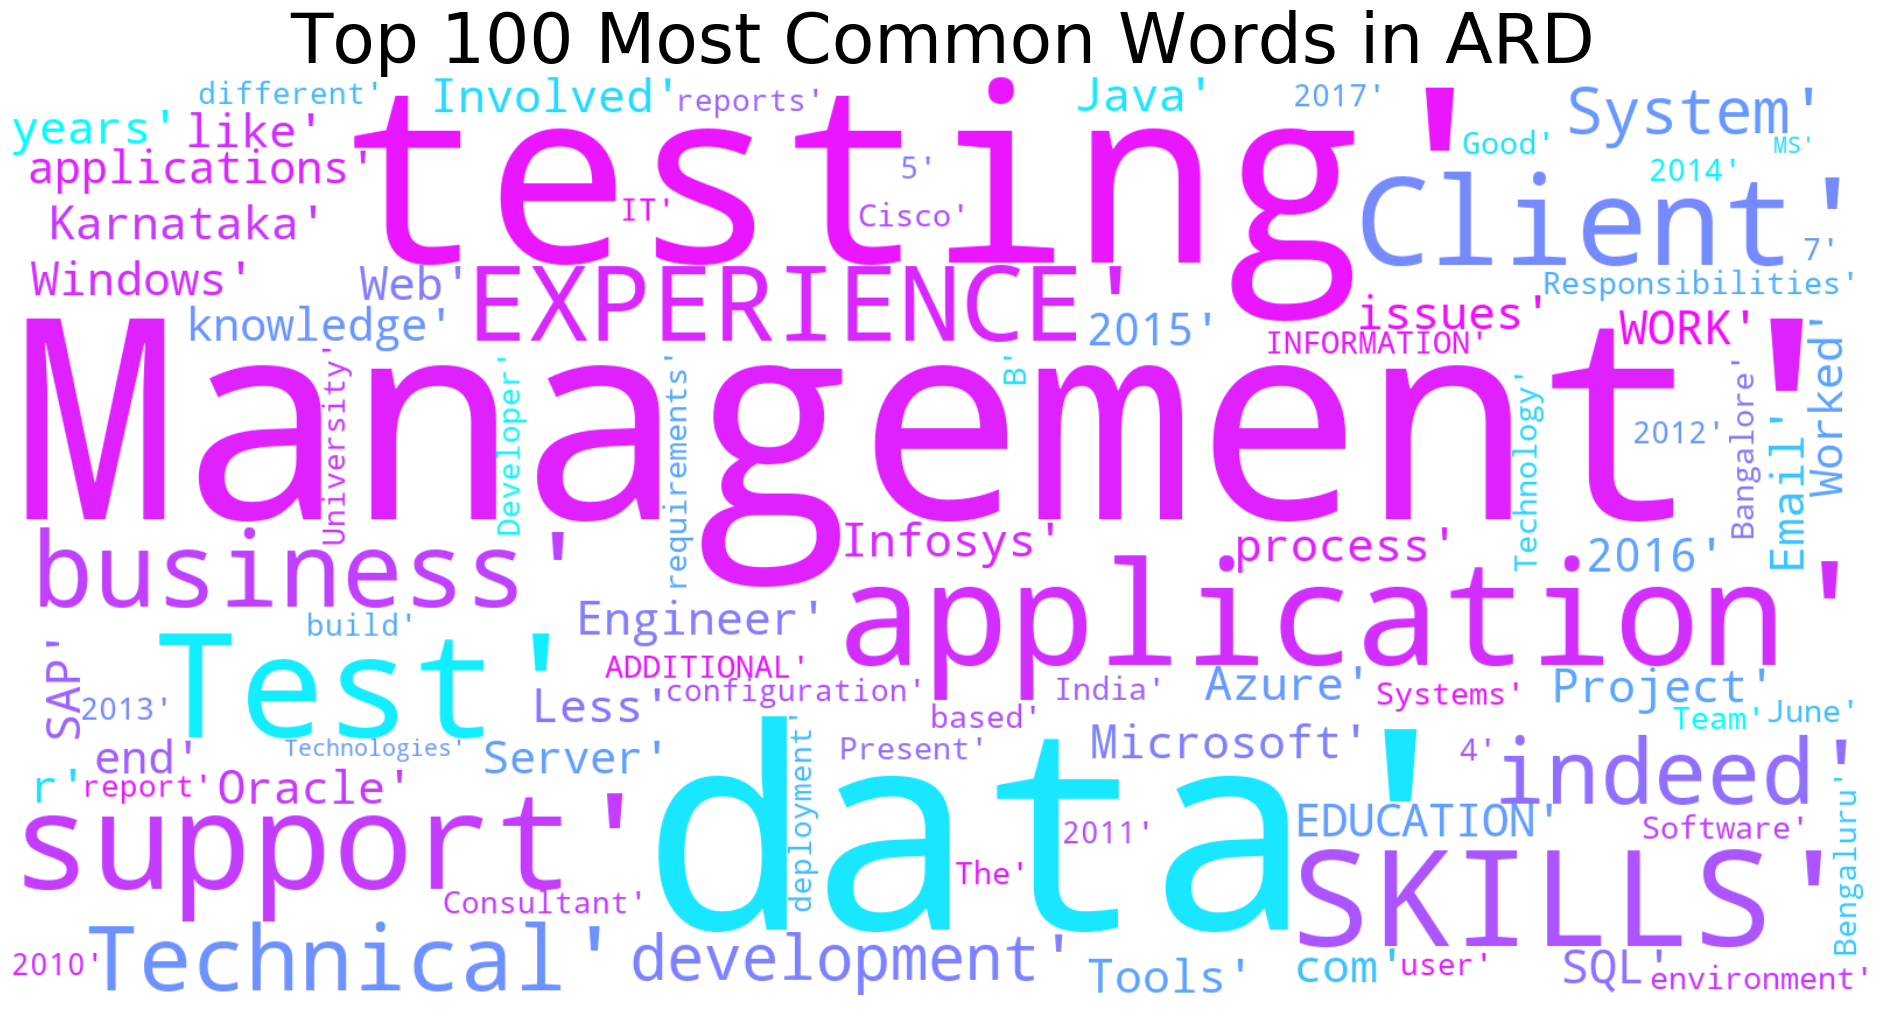

In [16]:
# Annotated resume data

mostcommon = FreqDist(json_df_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap = 'cool', stopwords=STOPWORDS).generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in ARD', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

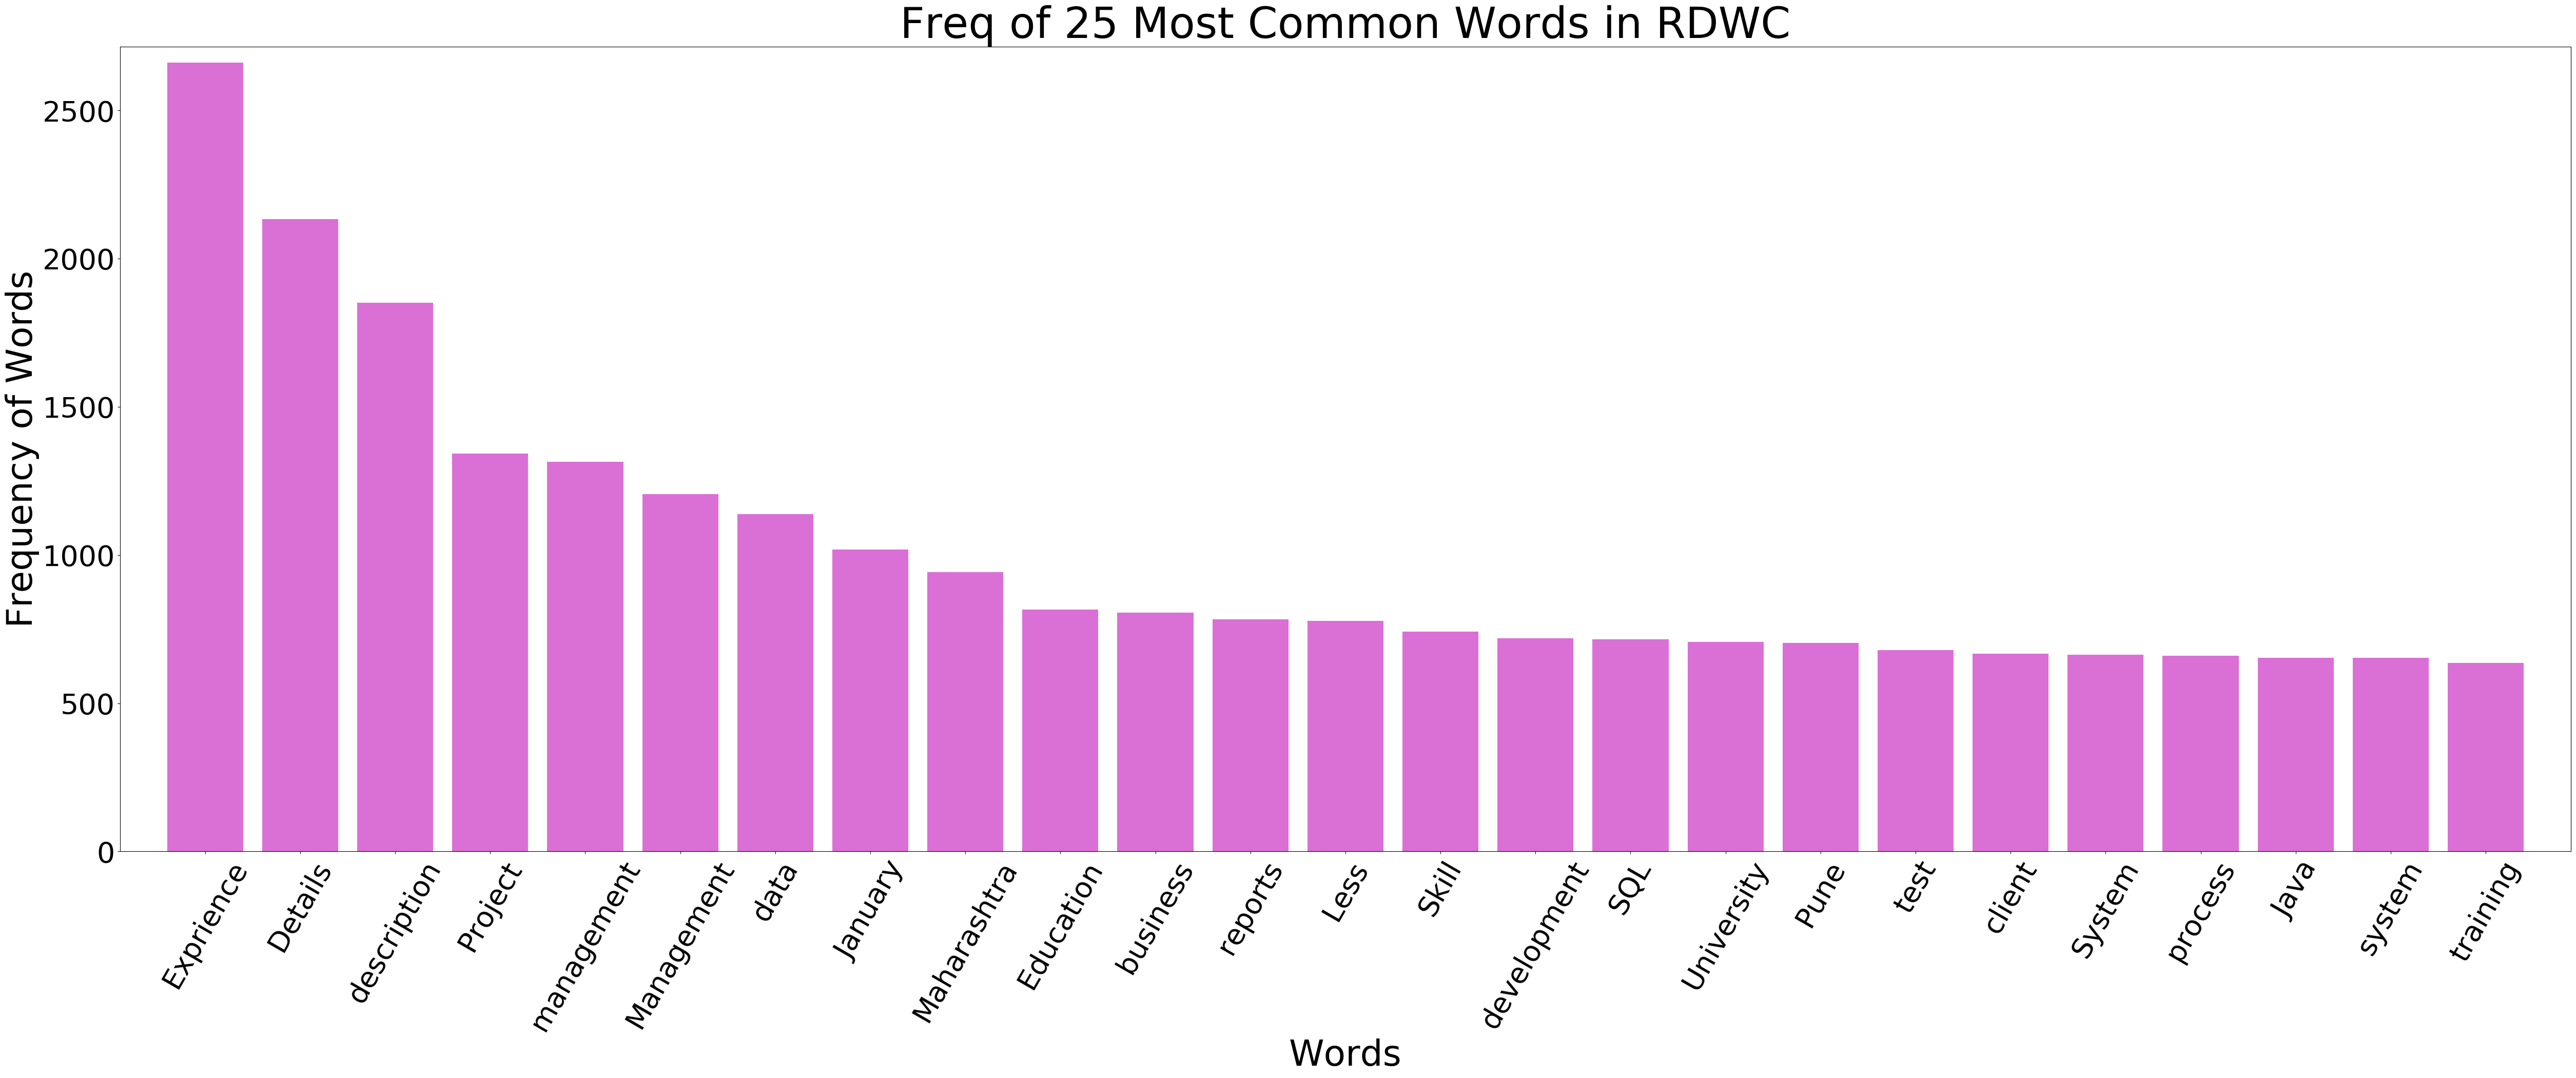

In [17]:
# Resume data with categories word frequency plot

mostcommon_small = FreqDist(csv_df_words).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,20))
plt.margins(0.02)
plt.bar(x, y, color = 'orchid')
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in RDWC', fontsize=60)
plt.show()

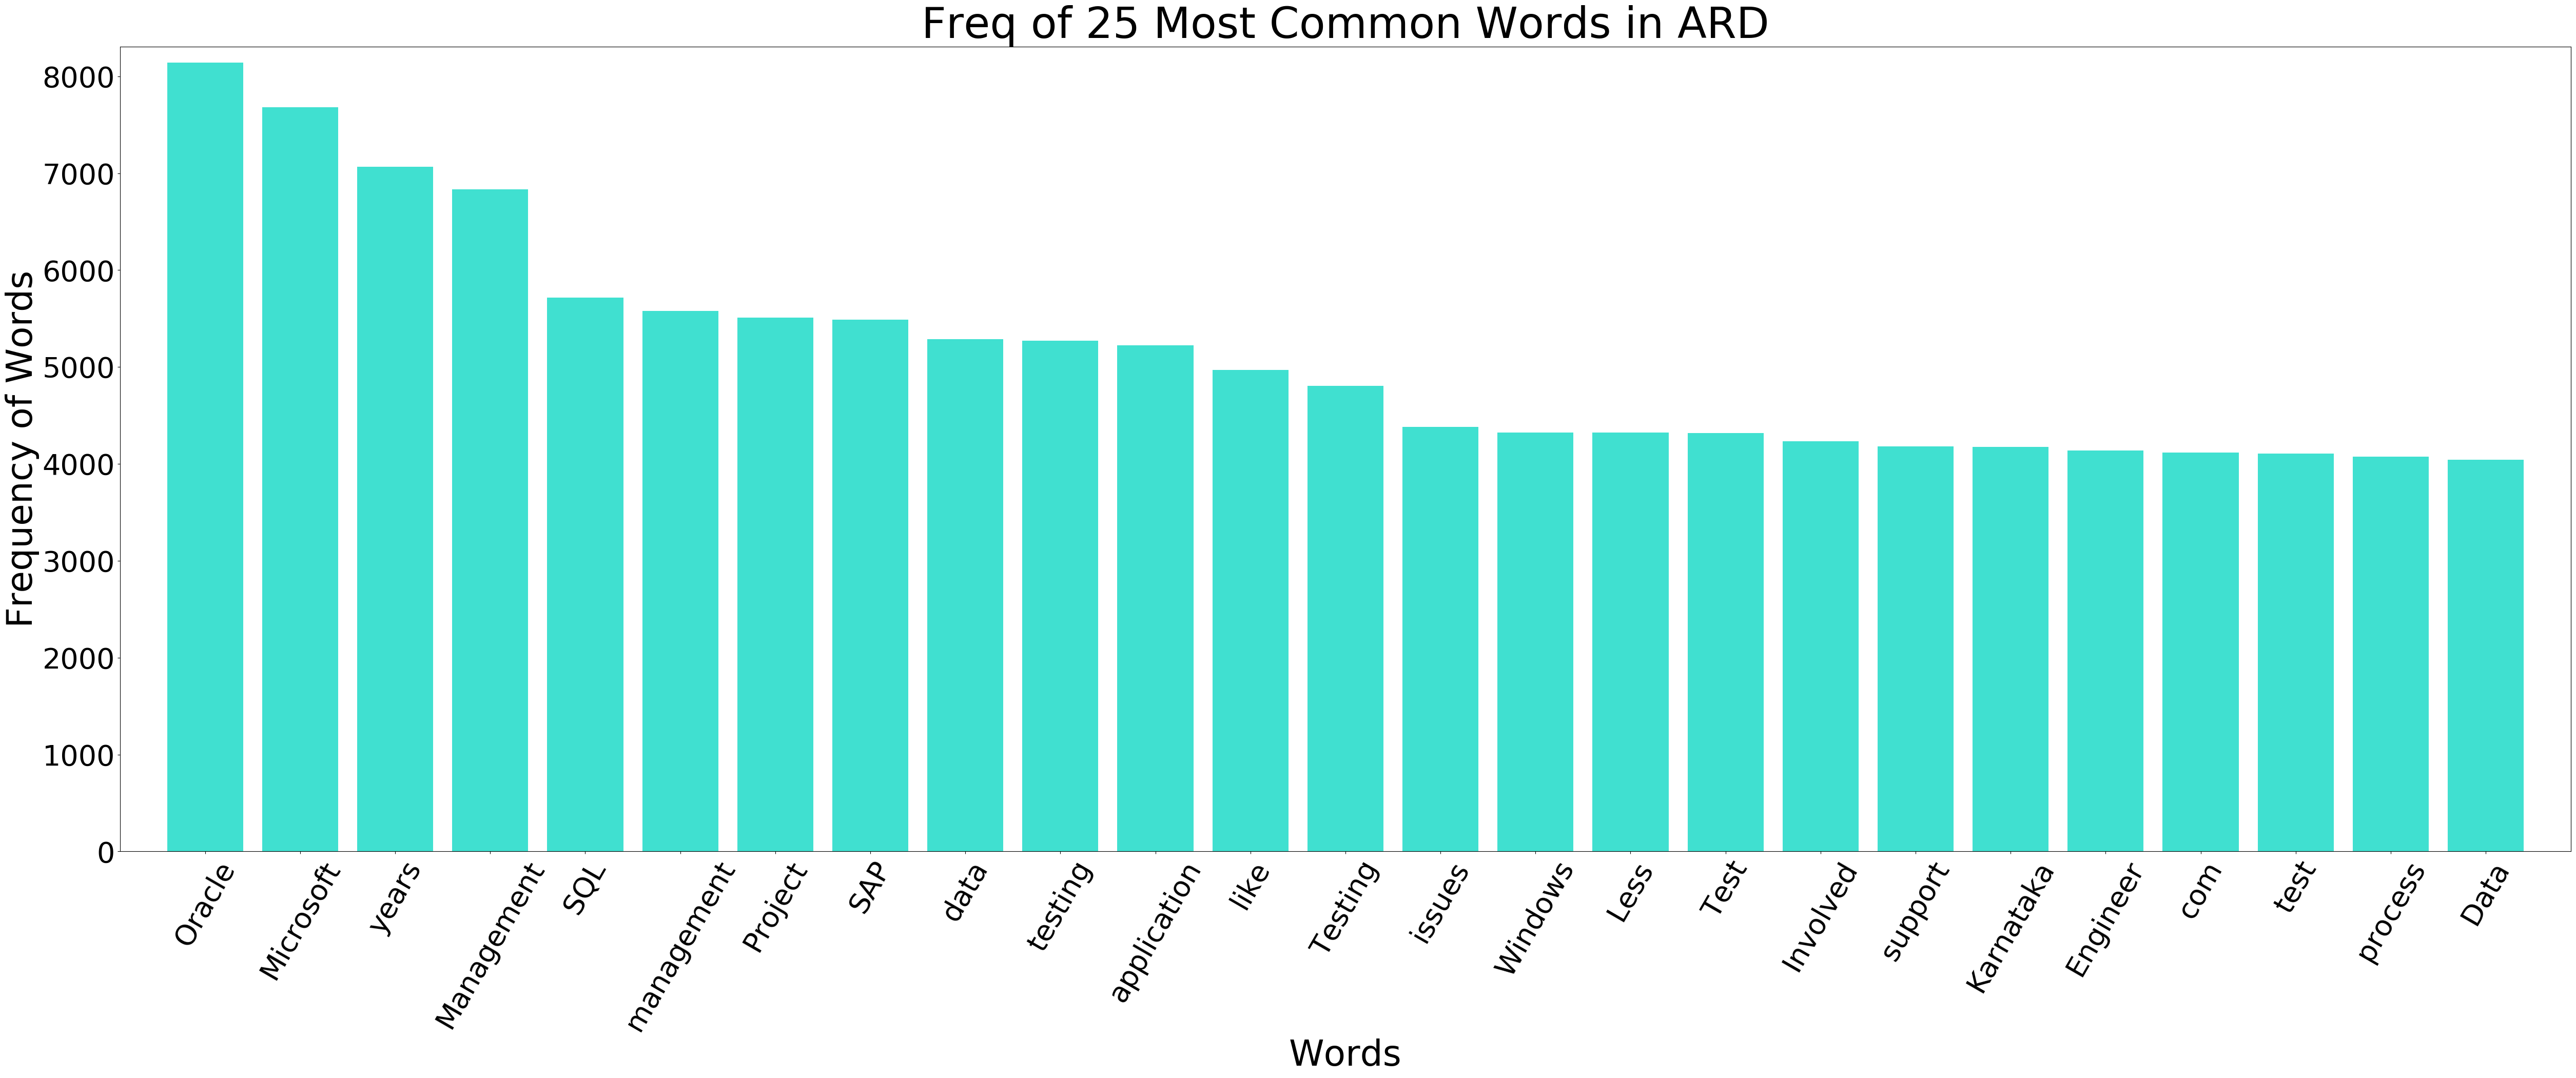

In [18]:
# Annotated resume data word frequency plot

mostcommon_small = FreqDist(json_df_words).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,20))
plt.margins(0.02)
plt.bar(x, y, color = 'turquoise')
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in ARD', fontsize=60)
plt.show()

---

## Similarity analysis

    Word embeddings and similarity measures can provide insight into the potential challenges of performing NER with the 
    available datasets by allowing us to compare different pieces of text and determine how closely related they are.
    
    By calculating the similarity between the text and each category, we can determine which category the text is most 
    likely to belong to. Similarly, by calculating the similarity between the text and each named entity, we can determine 
    which named entity the text is most likely to refer to.
    
    Instead of the widely used cosine similarity, I will use Earth movers distance(EMD) to illustrate word movers 
    distance(WMD). EMD is a general measure of the distance between two distributions, while WMD is a specific variant of 
    EMD that is designed for comparing the similarity between two sets of text data or word embeddings.
    
    EMD gives a good conceptual overview, WMD gives a good practical implementation. 
    
    
        ● Advantages
            - Considers the meaning of words, rather than just their presence or absence. This can be useful for tasks 
              where the meaning of words is important (NER component captures local context) so it is more sensitive to the 
              semantic relationships between words and can capture more nuanced differences in meaning
              
            - Is generally more robust to noise and variations in word usage, since it considers the relationships 
              between words rather than just their individual frequencies
            
    
        ● Disadvantages
            - Is generally more computationally expensive to calculate than cosine similarity since it involves gradient 
              descent to find the minimum distance between the words in the two pieces of text
              
            - Gradient descent makes it a bit less interpretable than cosine similarity
            
    
        ● Migitgation
            - Error and sensitivity analysis make interpretability a little easier, but will require context and domain 
              knowledge
              
            - WMD is more sensitive to noise and variations in word usage than cosine similarity, so standard 
              preprocessing techniques to remove noise are helpful (stemming, lemmatization, and stop word removal)
              
            - Normalizing the scale of the embeddings before calculating WMD can help mitigate computational expense, as 
              well as weighting the word vectors and reducing number of embedding dimensions     

In [19]:
'''Import GloVe word embeddings, create vocabulary and convert them to Word2Vec format
   Text file is a corpus of words, each line contains a word and its count

   GloVe vectors are filtered on this list to only include words that are present in the vocabulary set 
   created from the GloVe file. The filtered list creates a reduced version of the original model
   containing only our relevant words
'''

df = pd.DataFrame(csv_df_words, columns = ['resume'])

glove_file = datapath('/files/glove.6B.300d.txt')
g2w2v = os.path.join("files", "word2vec.6B.300d.bin.gz")

print("Loading GloVe Vectors")
%time 
model = KeyedVectors.load_word2vec_format(g2w2v, binary=True)
vocabulary = set(model.key_to_index)
base_dir = os.path.dirname(__file__)
wordcount_path = os.path.join(base_dir, 'files', 'resume_data_with_categories_word_counts.txt')
relevant_words = [word for (word, count) in read_1w_corpus(wordcount_path) if word in vocabulary]
model_reduced = model[[w for w in relevant_words]]

Loading GloVe Vectors
Wall time: 0 ns


In [20]:
'''Checks whether 'w2v_tsne.csv' exists. If it does not exist, 
   t-distributed Stochastic Neighbor Embedding is executed

   tSNE is initialized, t-SNE vectors are then stored in a dataframe 
   with columns 'c1', 'c2', and 'resume_skill_text' containing the 
   corresponding relevant words. The dataframe is then saved to the 'w2v_tsne.csv' file
'''

if not os.path.isfile('/files/w2v_tsne.csv'):
    tsne = TSNE(n_components=2, n_jobs=1, random_state=666)
    print("Performing TSNE on GloVe Vectors")
    %time 
    tsne_vectors = tsne.fit_transform(model_reduced.astype(np.float64)) 
    d = pd.DataFrame(tsne_vectors, columns=['c1', 'c2'])
    d['resume_skill_text'] = relevant_words
    d.to_csv('w2v_tsne.csv')
else:
    d = pd.read_csv('/files/w2v_tsne.csv', index_col=0)

Performing TSNE on GloVe Vectors
Wall time: 0 ns


In [21]:
'''Defines two lists of words from the nested text key in the annotated_data file that represent skills 
   for a java developer and one for an HR manager and indicates whether the word in the 'resume_skill_text' 
   column is a skill associated with a java developer, and the other indicating whether the word is a 
   skill associated with an HR manager
   
   isin() checks whether each word in the 'resume_skill_text' column of the 'd' dataframe is present in 
   either of the two lists, and adds a new column called 'skill_sentence_words_developer' or 
   'skill_sentence_words_hr' indicating whether the word appears in the respective list
'''    

# Java developer resume skills
skill_sentence_words_developer = ['andrioid' 'studio', 'git', 'scripts', 'java', 'database', 
                                  'algorithms','javascript','analysing']

# HR manager resume skills
skill_sentence_words_hr = ['leadership', 'strategic' 'management', 'troubleshooting', 
                           'verbal' 'communication', 'reviewing', 'support', 'supervision']

d['skill_sentence_words_developer'] = d['resume_skill_text'].isin(skill_sentence_words_developer)
d['skill_sentence_words_hr'] = d['resume_skill_text'].isin(skill_sentence_words_hr)

# Print first 2,000 rows
d.head(2000)

c1         c2 resume_skill_text  skill_sentence_words_developer  \
0     73.833786  3.993151   0                 False                            
1     73.460968  3.901213   1                 False                            
2     73.360451  3.899935   2                 False                            
3    -64.608231 -16.531654  2013              False                            
4     73.211555  3.891001   3                 False                            
5     73.017014  3.874503   4                 False                            
6     2.049087   68.938019  2017              False                            
7     72.822914  3.873544   5                 False                            
8     72.764099  3.857873   6                 False                            
9     72.557411  3.837444   7                 False                            
10    72.506218  3.840208   8                 False                            
11    72.344414  3.807941   9                 False                            
12    71.241058  4.461236   10                False                            
13    71.271416  3.514759   11                False                            
14    71.215942  3.898597   12                False                            
15    70.932663  3.721567   13                False                            
16    70.904671  3.780089   14                False                            
17    70.746124  4.397706   15                False                            
18    70.790154  3.827564   16                False                            
19    70.583206  3.695706   17                False                            
20    70.675285  4.330569   18                False                            
21    70.439049  3.627751   19                False                            
22    70.415764  4.844252   20                False                            
23    70.279625  3.665913   21                False                            
24    70.197380  3.691370   22                False                            
25    70.118973  3.593631   23                False                            
26    70.072296  4.093822   24                False                            
27    70.163193  4.675232   25                False                            
28   -48.947025 -29.037327  learning          False                            
29    70.000793  3.596967   26                False                            
30    69.932648  3.621775   27                False                            
31    69.964508  3.657927   28                False                            
32    69.896385  3.551307   29                False                            
33    70.202919  4.946033   30                False                            
34    69.683678  3.680184   31                False                            
35    70.711021  9.404076   32                False                            
36    70.768341  9.628893   33                False                            
37    70.816757  9.816991   34                False                            
38    69.811325  9.583927   35                False                            
39    70.859848  9.773552   36                False                            
40    70.785561  9.955159   37                False                            
41    70.789406  9.969618   38                False                            
42    70.845070  10.118004  39                False                            
43   -25.566366 -5.733469   description       False                            
44    67.994202  10.459661  40                False                            
45    70.929680  10.330747  41                False                            
46    70.904625  10.250937  42                False                            
47    50.004562 -27.920113  business          False                            
48    70.857986  10.470959  43                False                            
49   -29.6565

In [22]:
# Plot attributes that creates two new columns in the d DataFrame: 'colors'

d['colors'] = d.apply(colors, axis=1)
d['sizes'] = d.apply(sizes, axis=1)


# Creates two new dataframes d_normal and d_sentences by selecting rows from the original dataframe 
# based on the values in the skill_sentence_words_developer and skill_sentence_words_hr columns

d_normal = d.loc[lambda x: (x['skill_sentence_words_developer'] == False) & (x['skill_sentence_words_hr'] == False)]
d_sentences = d.loc[lambda x: (x['skill_sentence_words_developer'] == True) | (x['skill_sentence_words_hr'] == True)]


# Min/max values of the 'c1' and 'c2' columns in the d_sentences dataframe for plot region specification

xmin, xmax, ymin, ymax = (d_sentences['c1'].min()-1,
                          d_sentences['c1'].max()+1,
                          d_sentences['c2'].min()-1,
                          d_sentences['c2'].max()+1)

d_normal_limited = d_normal.loc[lambda x: (
    (x['c1'] > xmin) &
    (x['c1'] < xmax) &
    (x['c2'] > ymin) &
    (x['c2'] < ymax))]


'''Creates the sentence1_dist and sentence2_dist objects by passing tham as lists to 
   the PileDistribution class. * operator to unpack the lists into individual arguments

   Appends a new DirtPile to the sentence1_piles list, using the values in the c1 and c2 columns as the 
   position of the pile and the value in the resume_skill_text column as the label for the pile. 
   If the value of skill_sentence_words_developer is False, the code does the same thing, but appends the 
   DirtPile object to the sentence2_piles list instead.
   
   This creates a PileDistribution object for each list, containing the dirt piles in the list as elements.
'''

sentence1_piles = []
sentence2_piles = []

for word in d_sentences.to_dict(orient='rows'):
    if word['skill_sentence_words_developer']:
        sentence1_piles.append(DirtPile((word['c1'], word['c2']), 1, word['resume_skill_text']))
    else:
        sentence2_piles.append(DirtPile((word['c1'], word['c2']), 1, word['resume_skill_text']))
        
sentence1_dist = PileDistribution(*sentence1_piles)
sentence2_dist = PileDistribution(*sentence2_piles)


'''Generates earth mover's distance between the two distributions represented by sentence1_dist and 
   sentence2_dist. EMD is a measure of the distance between two probability distributions. It quantifies 
   the amount of work required to transform one distribution into the other

   The generate_signatures function generates the positions and mass distributions of the two 
   distributions. The mass distributions are then passed to the euclidean_distances function along with the 
   positions to compute the distance matrix between the piles

   The emd_with_flow function is then called with the two mass distributions and the distance matrix as input to 
   compute the EMD and the flow between the two distributions. The EMD and flow are stored in 
   sentence_emd and sentence_flow
'''

sentence_positions, sentence_p1_signature, sentence_p2_signature = generate_signatures(sentence1_dist, sentence2_dist, normalize = True)

sentence_dist = euclidean_distances(sentence_positions, sentence_positions)

sentence_emd, sentence_flow = emd_with_flow(np.array(sentence_p1_signature), np.array(sentence_p2_signature), sentence_dist)

---

### t-Distributed Stochastic Neighboring Embeddings for EDA

    Assuming semantic relationships are in the data, relationships like this are highly dimensional. So its best to use a 
    visualization technique that can undercover trends not easily visualized by standard plots. 

    Dimensionality reduction using t-SNE projects high-dimensionsal data into a lower-dimensional space.

    The plot shows that there is ambiguity in the dataset. Words from different job categories can be close together, which 
    can make it hard to execute prediction tasks because classes can share words. So any contextual information or other
    subtle shades of meaning we can leverage will be useful. This is why we need NER to provide additional context to 
    the learning objective.

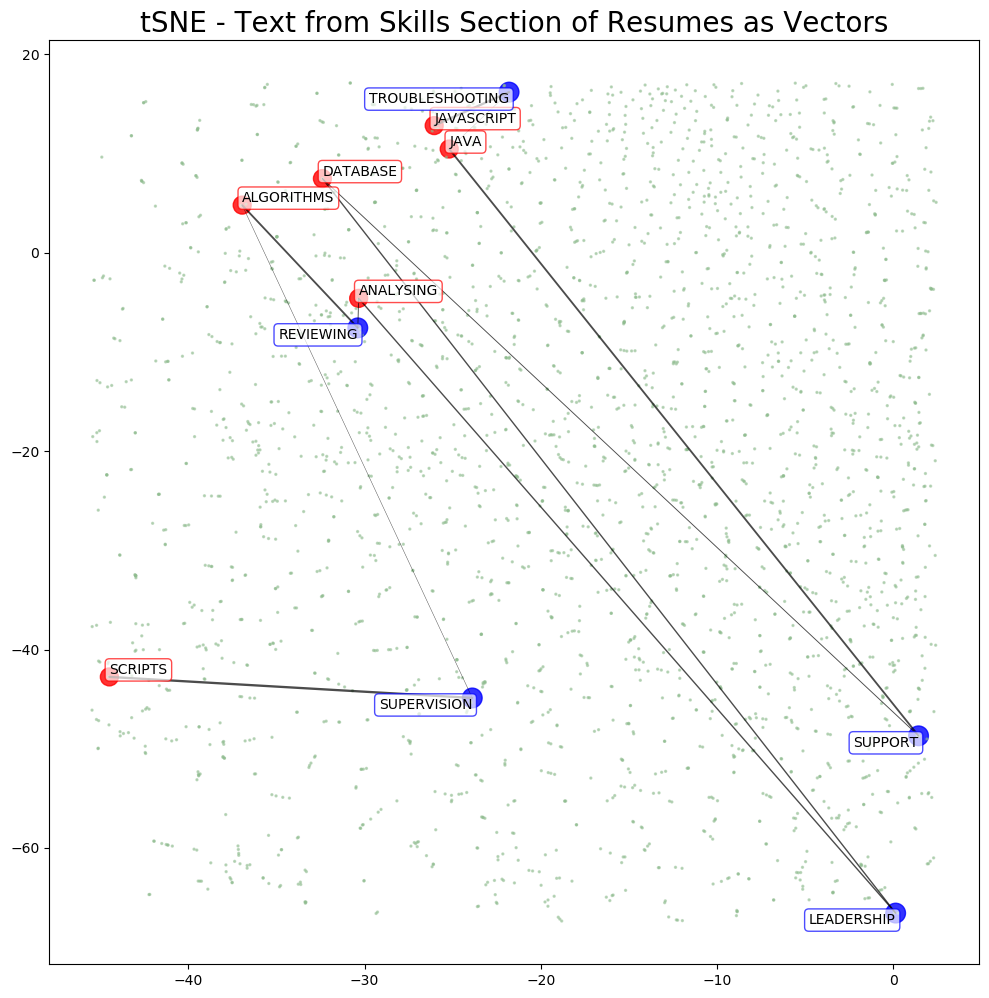

In [23]:
# Vector coordinates from the actual wmd are taken from observations in the data to display here

'''
   Positions of the two distributions of our observartions on a 2D plane, and 
   the flow between them using lines connecting the piles. The dirt piles are represented as circles, 
   with the size of the circles representing the mass of the piles and the colors representing the distribution they 
   belong to. The lines connecting the piles in the two distributions show the 
   flow between the piles
   
   The flow between piles refers to the way the weights between the two sets being compared are 
   redistributed in order to transform one set into the other. The redistribution helps us 
   minimize the total distance that needs to be traveled which is an important factor in determining the
   distance between two sets.
   
   In our case, the flow between words from each class is important because it helps to determine the most 
   efficient way to transform one set of points into the other so we can minimize the total distance that 
   needs to be traveled
   LISTEN TO RACHAEL TATMANS EXPLAINATION TO HELP WITH LAYMEN INTUITION
'''

plot_emd_solution(sentence1_dist, sentence2_dist, sentence_positions, sentence_emd, 
                  np.array(sentence_flow), figsize=(12, 12), r_scale=1000)

plt.scatter(x=d_normal_limited['c1'], y=d_normal_limited['c2'], c=d_normal_limited['colors'], 
            alpha=.5, s=d_normal_limited['sizes'] + 1, );

for word in d_sentences.to_dict(orient='rows'):
    if word['skill_sentence_words_hr']:
        plt.annotate(xy=[word['c1'], word['c2']],
                     s=word['resume_skill_text'].upper(),
                     textcoords='data',
                     horizontalalignment='right',
                    verticalalignment='top',
                     bbox=dict(boxstyle="round", fc="w", ec="b", alpha=0.7))
    else:
        plt.annotate(xy=[word['c1'], word['c2']] ,
                     s=word['resume_skill_text'].upper(),
                     textcoords='data',
                    horizontalalignment='left',
                    verticalalignment='bottom',
                     bbox=dict(boxstyle="round", fc="w", ec="r", alpha=0.7))

plt.title('tSNE - Text from Skills Section of Resumes as Vectors', fontsize=20)
plt.show()

---

# Model Training

In [24]:
# Format annotated data for spacy
json_path = os.path.join(base_dir, 'files', 'annotated_data.json')
data = trim_entity_spans(convert_rh_annotated_data_to_spacy(json_path))

# Initialize training data and testing data
train_data, test_data = train_test_split(data, test_size = 0.0, random_state = 42)

# Train the model
nlp = train_spacy()

# Save the model to disk for further use
model_path = os.path.join(base_dir, 'files', 'rh_ner_model')
nlp.to_disk(model_path)

Starting epoch 0
{'ner': 27924.898148149383}
Starting epoch 1
{'ner': 21986.932216079513}
Starting epoch 2
{'ner': 19456.377688000444}
Starting epoch 3
{'ner': 14512.434038359597}
Starting epoch 4
{'ner': 12956.328813639124}
Starting epoch 5
{'ner': 13925.29578271437}
Starting epoch 6
{'ner': 11319.40307205819}
Starting epoch 7
{'ner': 11560.44568270113}
Starting epoch 8
{'ner': 8704.285497510049}
Starting epoch 9
{'ner': 9796.332196103534}
Starting epoch 10
{'ner': 8992.576721193282}
Starting epoch 11
{'ner': 9662.325311409608}
Starting epoch 12
{'ner': 7977.04047306407}
Starting epoch 13
{'ner': 8351.024370491028}
Starting epoch 14
{'ner': 8410.128677167213}
Starting epoch 15
{'ner': 7530.6640102097035}
Starting epoch 16
{'ner': 8595.266679930368}
Starting epoch 17
{'ner': 7580.0939385100855}
Starting epoch 18
{'ner': 7131.574657411132}
Starting epoch 19
{'ner': 6876.267208920832}
Starting epoch 20
{'ner': 6523.635012787681}
Starting epoch 21
{'ner': 6934.867504044255}
Starting epoch

In [25]:
'''Creates a GoldParse object using the nlp model and the list of entities, and assigns it to a 
variable called gold. The GoldParse object is a spaCy object that holds information about 
the entities in a text. 
'''

y_test = []
y_pred = []

for text, annots in train_data:
    
    gold = GoldParse(nlp.make_doc(text), entities = annots.get("entities"))
    ents = gold.ner
    pred_ents = doc_to_bilou(nlp, text)
    
    y_test.append(ents)
    y_pred.append(pred_ents)

---

# Evaluation

Based on accuracy from last run and the data in the 'rh ner perf metrics' folder, it looks like entities of interest
are under represented

In [26]:
# Prints evaluation report, accuracy & loads trained NER model

report, accuracy = ner_report(y_test, y_pred)
model_path = os.path.join(base_dir, 'files', 'rh_ner_model')
resume_nlp = spacy.load(model_path)
print(report)
print("Model Accuracy:", accuracy)

                       precision    recall  f1-score   support

                    -       0.00      0.00      0.00      2811
       B-College Name       0.88      0.97      0.92       273
       I-College Name       0.80      0.94      0.87       560
       L-College Name       0.85      0.93      0.89       276
       U-College Name       1.00      0.93      0.96        14
B-Companies worked at       0.80      0.94      0.86       254
I-Companies worked at       0.34      0.73      0.47       153
L-Companies worked at       0.76      0.85      0.80       266
U-Companies worked at       0.90      0.88      0.89       386
             B-Degree       0.84      0.95      0.89       195
             I-Degree       0.81      0.95      0.87       563
             L-Degree       0.82      0.92      0.87       195
             U-Degree       0.86      0.86      0.86        65
        B-Designation       0.85      0.97      0.91       428
        I-Designation       0.89      0.94      0.91  

---

# Model Testing

In [27]:
# Sample texts
texts = [
    "SKILLS C Basics IOT Python MATLAB Data Science Machine Learning HTML Microsoft Word Microsoft Excel Microsoft Powerpoint. RECOGNITION Academic Secured First place in B.Tech.Education Details August 2014 to May 2018 B.Tech. Ghatkesar Andhra Pradesh Auroras Scientific and Technological Institute June 2012 to May 2014 Secondary Education Warangal Telangana SR Junior College Data Science Skill Details MS OFFICE- Exprience - Less than 1 year months C- Exprience - Less than 1 year months machine learning- Exprience - Less than 1 year months data science- Exprience - Less than 1 year months Matlab- Exprience - Less than 1 year monthsCompany Details company - description -",
    "Oracle RDBMS 10g 11g 12c Technology utilities Data Pump RMAN Data guard ASM RAC Golden Gate Tools OCC PUTTY SQLPLUS SQL Developer Netbackup SCOM SCCM VMWare Vsphere Operating Systems RHEL 6 0 RHEL 6 5 UNIX and Microsoft WindowsEducation Details Database Administrator Database Administrator BNY Mellon Skill Details DATABASES Exprience 24 months ORACLE Exprience 24 months RMAN Exprience 24 months NETBACKUP Exprience 24 months SCOM Exprience 24 monthsCompany Details company BNY Mellon description Databases 600 Team Size 8 Duration Jan 2017 Till Date Clients Over 130 investment banking organizations who are hosted with Eagle Responsibilities Database Management Support and managing critical production Pre production test and reporting databases in different platforms",
    "IT SKILLS Well versed with MS Office and Internet Applications and various ERP systems implemented in the company ie SAGE Flotilla LM ERP Tally 9 WMS Exceed 4000 etc PERSONAL DOSSIER Permanent Address Bandra West Mumbai 400 050Education Details B Com commerce Mumbai Maharashtra Bombay University Mumbai Maharashtra St Andrews College DIM Business Management. Job responsibilities Maintaining and updating the database of customers and suppliers Handling walk in customers and after sales service calls Preparing Job order Providing timely information and data for the preparation of reports Circulating information through memos and reports Invoicing for four major departments Banking Petty cashiering and preparing reports General office duties.",
    "Bengaluru India Developed and deployed auto preprocessing steps of machine learning mainly missing value treatment outlier detection encoding scaling feature selection and dimensionality reduction Deployed automated classification and regression model linkedin com in aditya rathore b4600b146 Reasearch and deployed the time series forecasting model ARIMA SARIMAX Holt winter and Prophet Worked on meta feature extracting problem github com rathorology Implemented a state of the art research paper on outlier detection for mixed attributes company Matelabs description Data Science",
    "John Doe received his Bachelor of Science in Computer Science from Stanford University in 2016. He is currently residing in San Francisco, California. You can reach him at john.doe@gmail.com. He also completed his Master’s in Artificial Intelligence from MIT in 2020.",
    "Worked as a Software Engineer at Google from 2018 to 2021, then promoted to Senior Software Engineer at Meta Platforms Inc. from 2021 to present. Previously interned at Dropbox during Summer 2017. Key roles involved backend microservice architecture and data infrastructure optimization.",
    "Priya Sharma holds an MBA in Human Resources from the Indian Institute of Management Ahmedabad, class of 2015. She has worked at Infosys and Deloitte as an HR Manager. She lives in Bengaluru and can be contacted via priya.hr@protonmail.com.",
    "Graduated from the University of Toronto in 2012 with a BA in Economics. Later earned an MSc in Data Analytics from the University of Edinburgh in 2015. Employed at Barclays as a Business Analyst, and at Accenture as a Data Consultant. Based in Toronto, Ontario."
]

# Loop through each sample
for i, text in enumerate(texts, 1):
    doc = resume_nlp(text)
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    displacy.render(doc, style='ent', jupyter=True)

---

### Performance
    
    Accuracy can give us a limited view of how a model is performing. The evaluation results say the model is capable of 
    achieving a high accuracy, anywhere from 77 to 95% (as a result of tuning the number of epochs and dropout 
    rate respectively). 
    
    But over multiple training runs the loss did not descend upon each epoch, it often doubled in size 
    after descending by a large amount every few epochs
    
    The training objective can be learned, but it cannot label more than a few words:

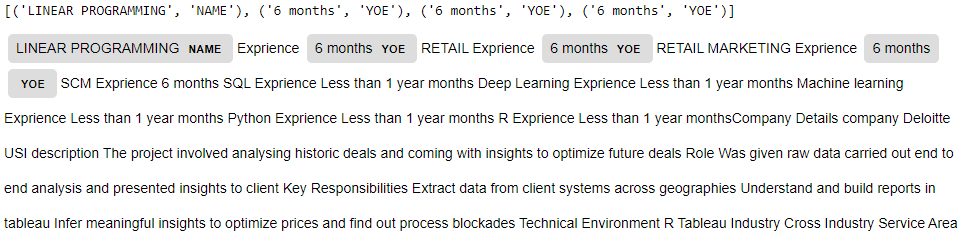

    I think the model is overfitting. It has high precision and recall on the training data but low precision and recall on 
    unseen data, qualitatively speaking
    
    Increasing the amount of dropout did not prevent the model from overfitting, it just prevented the model from reaching global minimum or maximum. At this point, the model would not even attempt to label unseen data
    
    I tried a number of conventional cleaning, standardizing methods
    
    Ultimately the number of training examples is very small. Poor generalization, overfitting and not being able to label 
    anything points to high variance. The quantitative results are misleading because the model can learn the objective, 
    but it cannot replicate the objective as it does not have a sufficient number of examples to learn from
    
        ● My top recommendation is to annotate additional training data. It's super boring, but its worth it if you 
          see a lift in predictions as your training set increases
    
    
    To increase performance we could collect additional training data for each label, specified to the needs of the 
    recruiting industry
    
        ● Extracting data from resumes is industry specific, there are not a lot of well annotated publicly available 
          specific to this task
          
        ● Annotation could be done using something like Prodigy to stay within the spacy ecosystem
    
        ● Additional data could be synthesized data using augmentation
        
        ● Leverage a pretrained transformer model via transfer learning
        
        
     After retraining the model with more examples, ideally at least 300 to 400 more, I would monitor the model for 
     drift, bias, performance and interpretability(if possible) to see if there are any significant deviations from the 
     expected performance:
     
        ● Has the distribution of the data the model is expected to receive, changed over time?
        
            - Performed earlier during EDA, this is on of the reasons why familiarity with the distribution of the data is 
              so important as you expect new data to be similar in distribution to the training data
              
            -Evaluate if there are internal or external factors that could impact performance
              
        ● Is the model biased against certrain groups of people or inputs?
        
            - Tracking its decisions over time for different groups or inputs can be automated with heuristics
            
        ● Interpretability can be tricky for neural models, but error analysis is our friend here
        
        ● Tools can be in place to monitor these phenomena, but having a human-in-the-loop and performing ad-hoc analysis 
          can also catch bad results early so that model retraining can happen as soon as possible.
        


### Observations and Improvements

    Advantages
        ● Speed
            - Spacy is pretty fast and efficient, so it can work well for large-scale NLP tasks
            
            - As long as you have enough data and represent your labels accurately, spacy can give state of the art 
              performance on a lot of NLP tasks
              
            - It has a simple and intuitive API
            - The community is very active so there is a lot of support
    
    Disadvantages
        ● Compatibility
            - If you're tied to a Hadoop based environment, spacy can be a pain to manage. Docker can solve this, but it 
              will require additional effort. Something like SparkNLP used on its own or with spacy could be the best move
              
        ● Training data
            - If the task you want to solve has publicly available data, great, otherwise you will need to annotate

    My 2¢:

      In my direct experience with nuanced, often messy data used for NER, as long as the labels are well defined and 
      annotated correctly, a spacy model will learn what you tell it to learn during training. You can even represent the 
      type of examples you would like to ignore, which makes the model robust to error. 
                
      You can even make it robust to "messy" data. Notice how this model can reach inside the quotes to retrieve the entity 
      'allograft'. 

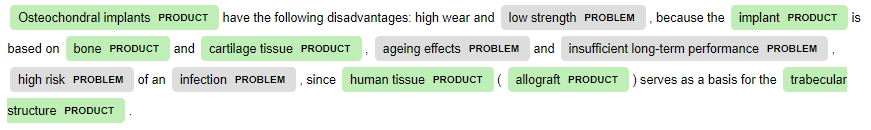

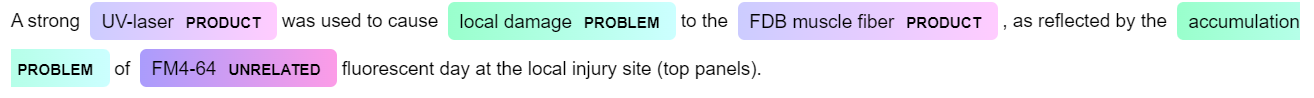

    Further optimizations would include using EMD/WMD to refine the retrieval aspect of the resumes NLP pipeline.

    Because we can find similar words in docuemnts with different semantics that we can define, this gives us a way to 
    disambiguate documents with similar language that are of different types. Pairing these embeddings with a classifier, 
    could hone in on specific areas of a document and compare how similar the embeddings are to a range of document types. 

    For example, let's say we have a bot combing through online job boards and that bot parsed 1 document with multiple 
    sections made up of words that belong to predefined resume labels (skills, years of experience, schools, former 
    employer) of predefined high-level job classes (tech, creative, business, communications). Because resumes are 
    documents and documents are groups of words and there are sets of words in sections of a document, we could classify 
    sections of the document with some degree of certainty. Use WMD to calculate the distance between the words in the new 
    document n to the predefined classes k, see how similar or dissimilar they are based on a score caluculated by the 
    similarity, have a multi-class classifier decide which class that section belongs to, and then run an NER model on 
    those newly classified words and extract the entities that define the class.

---

---

# Business Insights

    ● Technology and people operations are in high demand
        
    ● Latent information in this data could give recruiters an opportunity to empower their candidates by
    
    ● This information can be useful for job seekers looking to tailor their resumes to specific categories, and also 
      useful when determining important classification features
    
    ● For complex automated decision making, more data is critical
    
    ● We all know that short and succient resumes are the best resumes, but trends suggest candidates tailoring their 
      resumes for technical roles should be more descriptive about their professional experience to highlight their 
      technical knowledge
      
          - On the backend we can leverage descriptive language and to further disambiguate high-level candidate classes 
            and create more seperation between classes
            
    ● Identifying qualified candidates for in demand positions relies on better resume classification         